# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальными признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

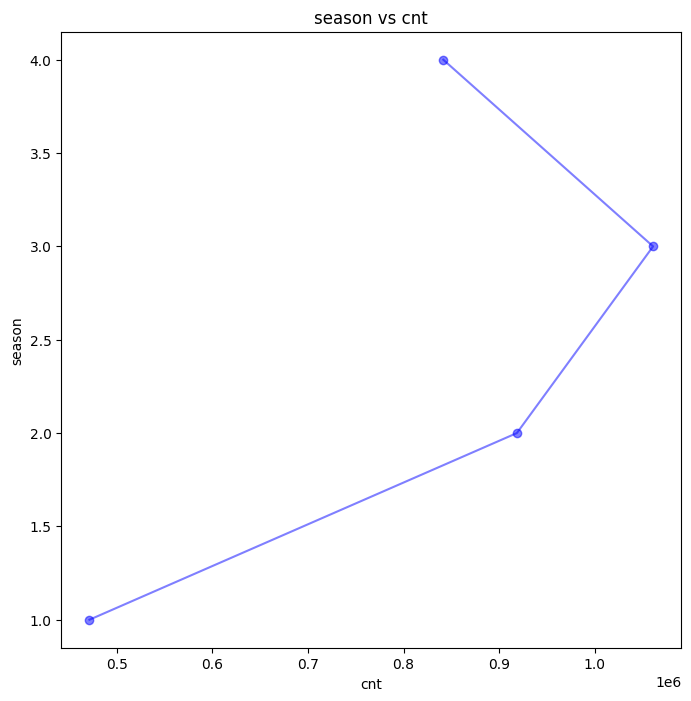

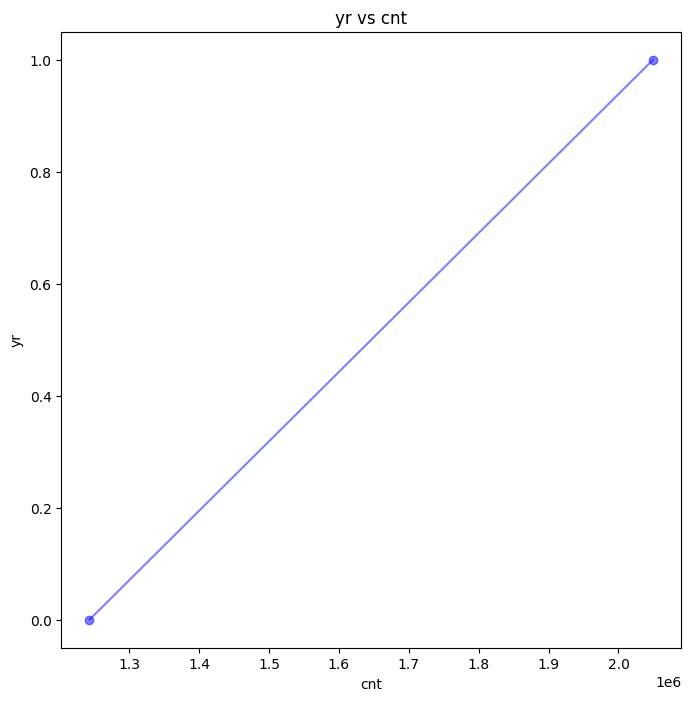

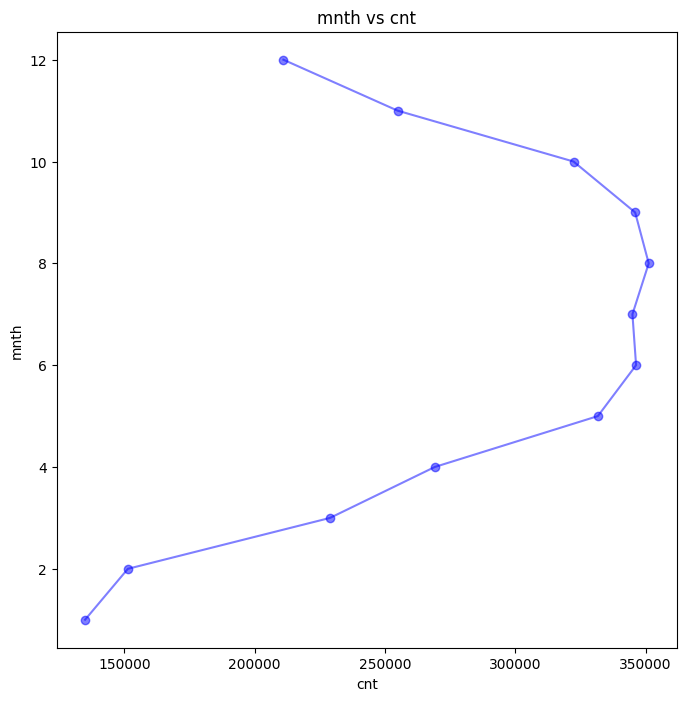

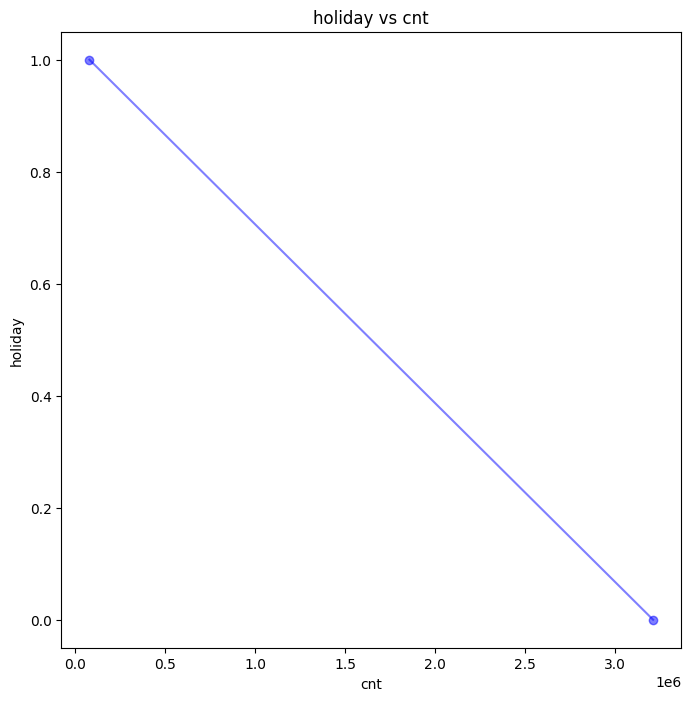

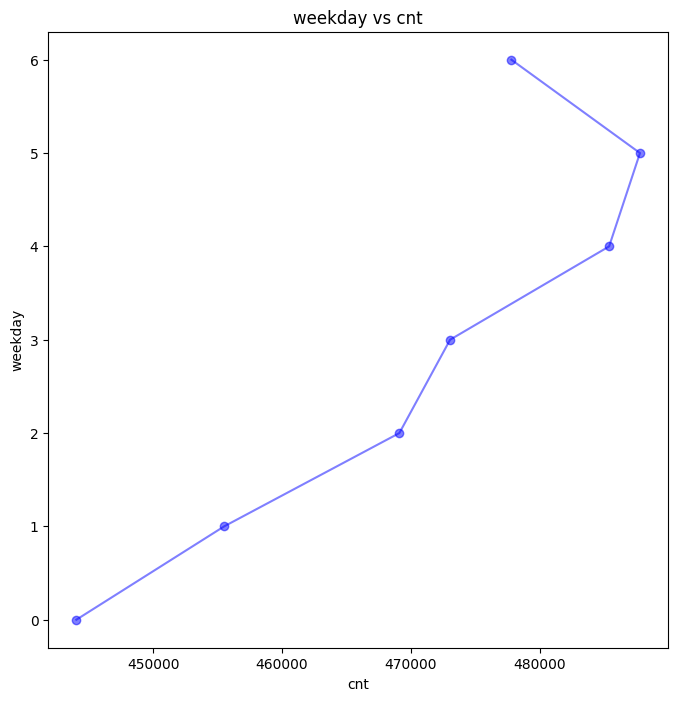

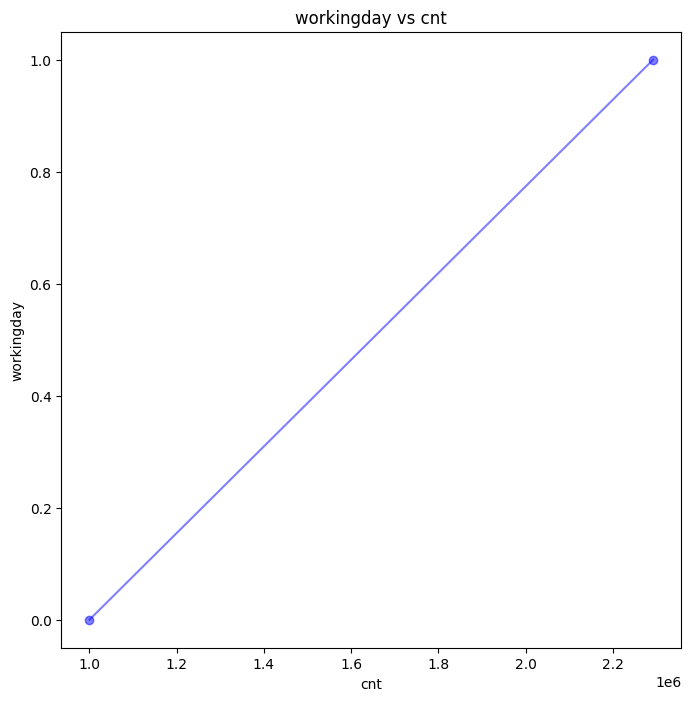

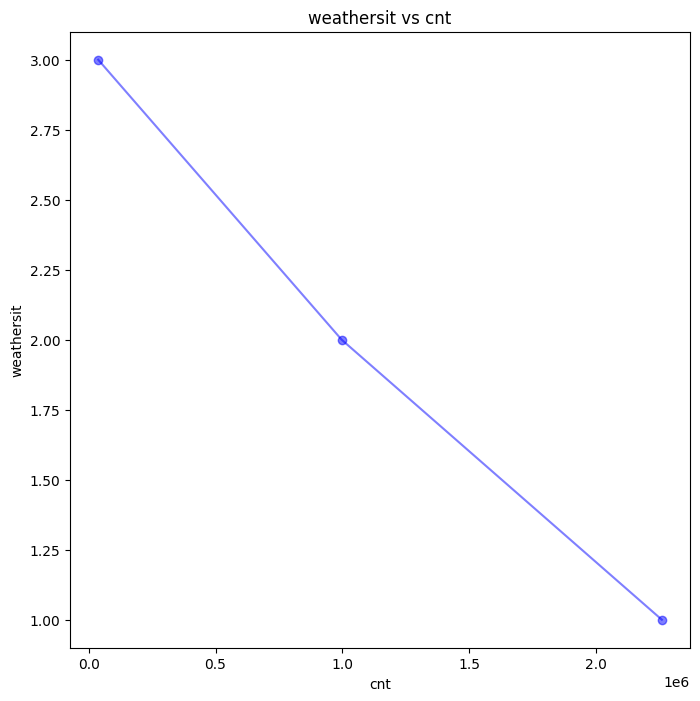

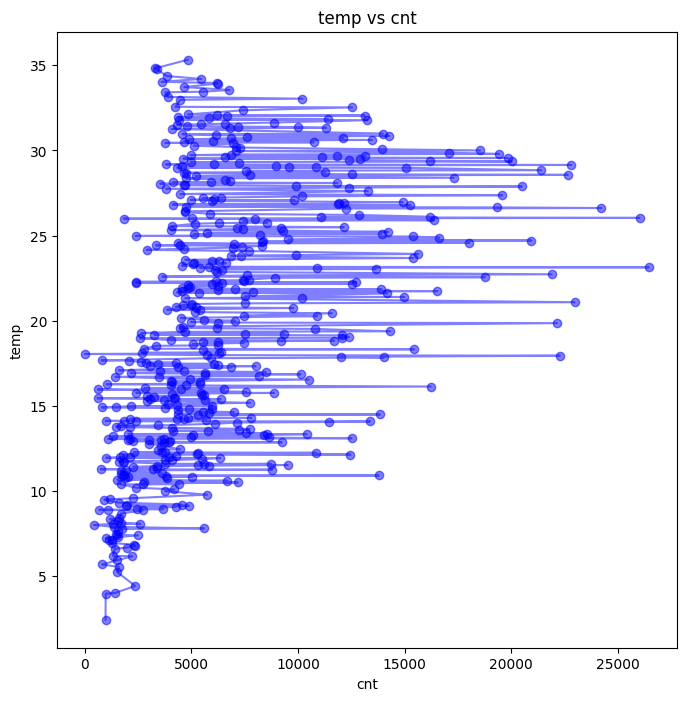

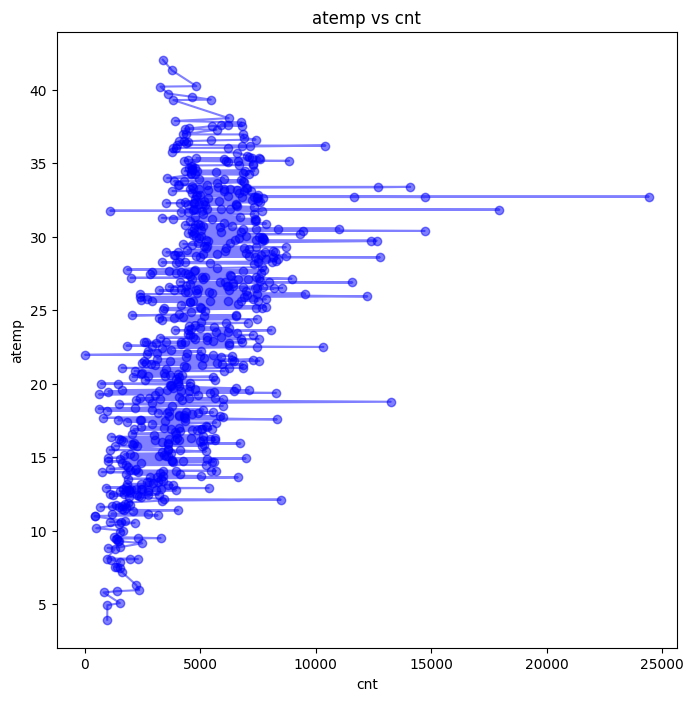

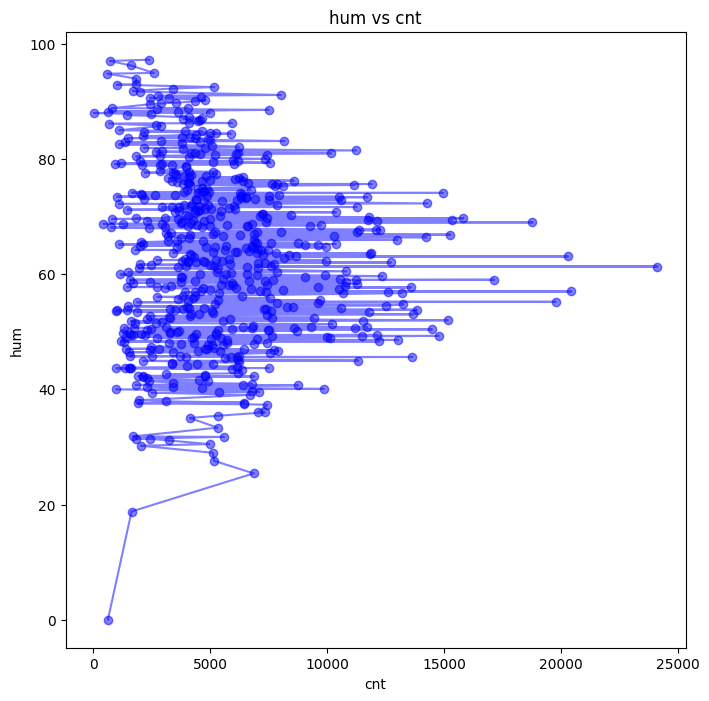

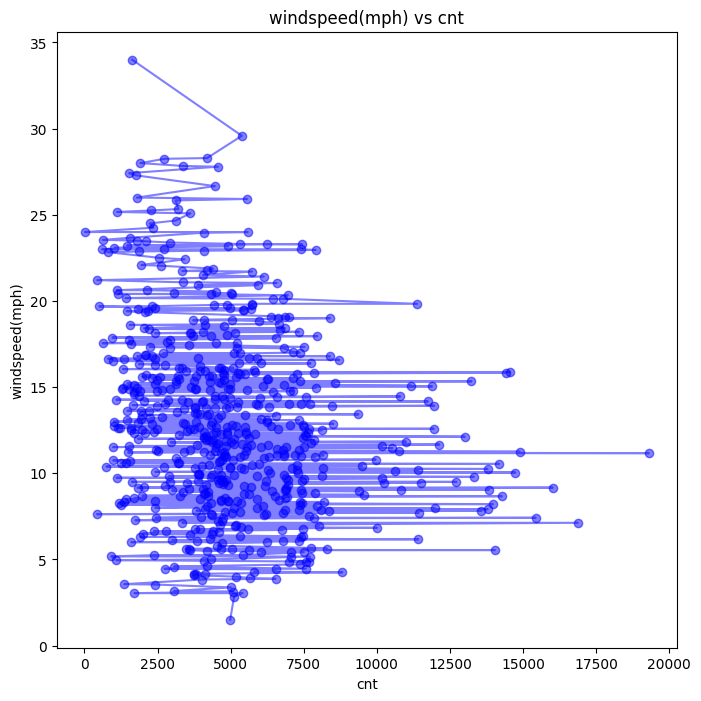

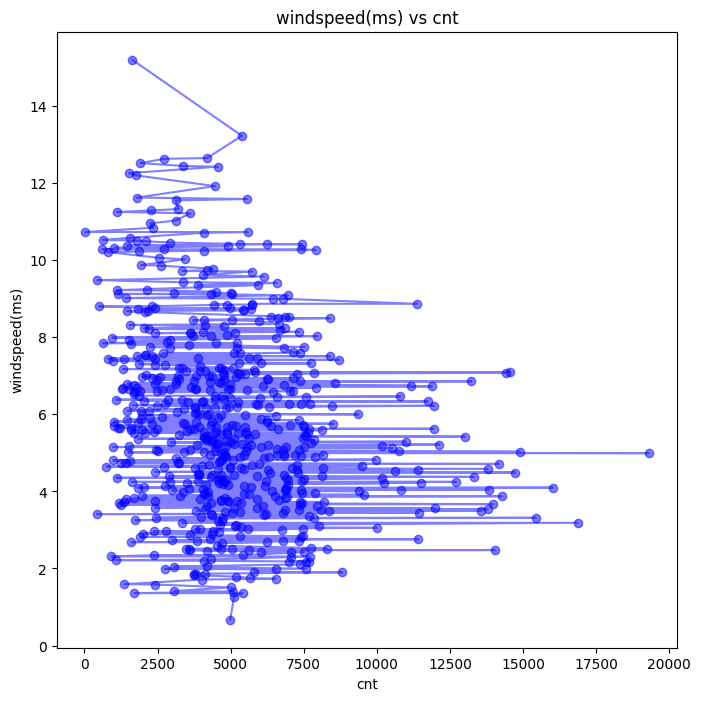

In [96]:
# Группировка данных по категориям и суммирование количества заказов


for column in df.columns:
    if column != 'cnt':
        category_sum = df.groupby(column)['cnt'].sum().reset_index()  # общая сумма заказов относительно признака

        fig, ax = plt.subplots(figsize=(8,8))
        plt.plot(category_sum['cnt'], category_sum[column], marker='o', color="b", alpha=0.5)
        plt.title(f'{column} vs cnt')
        plt.xlabel('cnt')
        plt.ylabel(column)
        plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца? Ответ: нелинейная зависимость.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно. Ответ: Согласно диаграмме корреляции (приведена ниже), наибольшая корреляция наблюдается у "temp", "atemp", "season", а также "yr". Однако, из графиков выше однозначно можно сказать только про логичную линейность зависимости "weathersit". Частичная логичная линейность просматривается у "season".

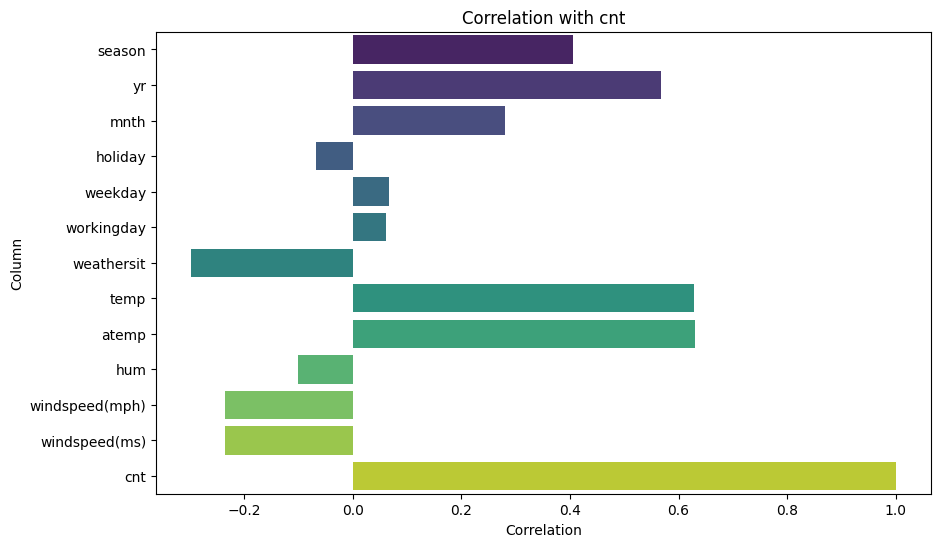

In [97]:
# Для определения признаков с линейной зависимостью, дополнительно проанализируем их корреляцию относительно 'cnt'.
import seaborn as sns
# Вычисление корреляции между выбранной колонкой и всеми остальными
correlation_matrix = df.corrwith(df['cnt'])
# Создание DataFrame для удобства работы с данными
correlation_df = pd.DataFrame({'Column': correlation_matrix.index, 'Correlation': correlation_matrix.values})
# Построение диаграммы корреляции
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Column', data=correlation_df, palette='viridis', hue='Column', dodge=False, legend=False)
plt.title(f'Correlation with cnt')
plt.show()

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [5]:
# Корреляция была посчитана выше. Здесь выведем ее точные числовые значения.
correlations = df.corrwith(df['cnt'])
correlations[:-1]

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [6]:
correlation_matrix = df.corr()
correlation_matrix

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [7]:
# Вычисляем средние значения для всех признаков.
feature_means = df.mean()
print(f"Средние значения признаков:\n{feature_means}\n")
# Вычислим доли 1 (процент признаков со значением "1") у бинарных (имеют только два значения: "1" или "0") признаков.
# Итерируемся по колонкам df
for column in df.columns:
    # Выбираем только бинарные колонки
    if df[column].isin([0, 1]).all():
        # Считаем долю единиц
        ones_ratio = df[column].mean()
        # Выводим результат
        print(f"Колонка: {column}, Доля единиц: {ones_ratio}")

Средние значения признаков:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Колонка: yr, Доля единиц: 0.5006839945280438
Колонка: holiday, Доля единиц: 0.028727770177838577
Колонка: workingday, Доля единиц: 0.6839945280437757


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)  # перемешивание строк в df
X = scale(df_shuffled[df_shuffled.columns[:-1]])  # масштабирование всех признаков, кроме последнего
y = df_shuffled["cnt"]  # назначение целевой переменной

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [10]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.

In [11]:
# создаем объект линейного регрессора
model = LinearRegression()
# проводим его обучение на всех данных df
model.fit(X, y)
# выведем веса модели
for feature, weight in zip(df.columns, model.coef_):
    print(f"Признак: {feature}, Вес: {weight}")

Признак: season, Вес: 570.863641661725
Признак: yr, Вес: 1021.9604245185086
Признак: mnth, Вес: -141.3006331900142
Признак: holiday, Вес: -86.75760471139698
Признак: weekday, Вес: 137.2272583151452
Признак: workingday, Вес: 56.38980357474366
Признак: weathersit, Вес: -330.2271825899341
Признак: temp, Вес: 367.4799030832653
Признак: atemp, Вес: 585.5521797658965
Признак: hum, Вес: -145.6155228231448
Признак: windspeed(mph), Вес: 12454356291009.727
Признак: windspeed(ms), Вес: -12454356291208.188


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [13]:
from sklearn.linear_model import Lasso
# создаем модель с Lasso-регуляризацией
alpha = 0.01  # параметр регуляризации
lasso_model = Lasso(alpha=alpha)
# обучаем модель
lasso_model.fit(X, y)
# выведем веса модели
for feature, weight in zip(df.columns, lasso_model.coef_):
    print(f"Признак: {feature}, Вес: {weight}")

Признак: season, Вес: 565.8203680344196
Признак: yr, Вес: 1020.3406075451142
Признак: mnth, Вес: -134.4059930589025
Признак: holiday, Вес: -86.6933353823502
Признак: weekday, Вес: 138.34178084851774
Признак: workingday, Вес: 55.945973205301776
Признак: weathersit, Вес: -332.69927432554397
Признак: temp, Вес: 372.4134136547166
Признак: atemp, Вес: 580.6345091628926
Признак: hum, Вес: -144.99533064129716
Признак: windspeed(mph), Вес: -198.08863723940627
Признак: windspeed(ms), Вес: -3.837859988283275e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [15]:
from sklearn.linear_model import Ridge
# создаем модель Ridge-регуляризацией
alpha = 0.1   # параметр регуляризации
ridge_model = Ridge(alpha=alpha)
# обучаем модель
ridge_model.fit(X, y)
# выведем веса модели
for feature, weight in zip(df.columns, ridge_model.coef_):
    print(f"Признак: {feature}, Вес: {weight}")

Признак: season, Вес: 565.5927961447952
Признак: yr, Вес: 1020.2102053573389
Признак: mnth, Вес: -134.20179351818396
Признак: holiday, Вес: -86.69921614667187
Признак: weekday, Вес: 138.32312010907393
Признак: workingday, Вес: 55.95017182416044
Признак: weathersit, Вес: -332.66278693635724
Признак: temp, Вес: 372.9090809742715
Признак: atemp, Вес: 580.1125852260768
Признак: hum, Вес: -145.01904705128925
Признак: windspeed(mph), Вес: -99.0604456580326
Признак: windspeed(ms), Вес: -99.06044638789834


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [22]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # создаем модель с Lasso-регуляризацией
    lasso_model = Lasso(alpha=alpha)
    # обучаем модель
    lasso_model.fit(X, y)
    # добавляем список весов в список coefs_lasso
    coefs_lasso.append(lasso_model.coef_)

    # создаем модель с Lasso-регуляризацией
    ridge_model = Ridge(alpha=alpha)
    # обучаем модель
    ridge_model.fit(X, y)
    # добавляем список весов в список coefs_lasso
    coefs_ridge.append(ridge_model.coef_)

# Конвертируем списки весов в массив NumPy
lasso_array = np.array(coefs_lasso)
ridge_array = np.array(coefs_ridge)
# Выведем массивы весов
print(f'Lasso coefs:\n{lasso_array}')
print(f'Ridge coefs:\n{ridge_array}')

Lasso coefs:
[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.787756

Проанализируйте динамику весов при увеличении параметра регуляризации:

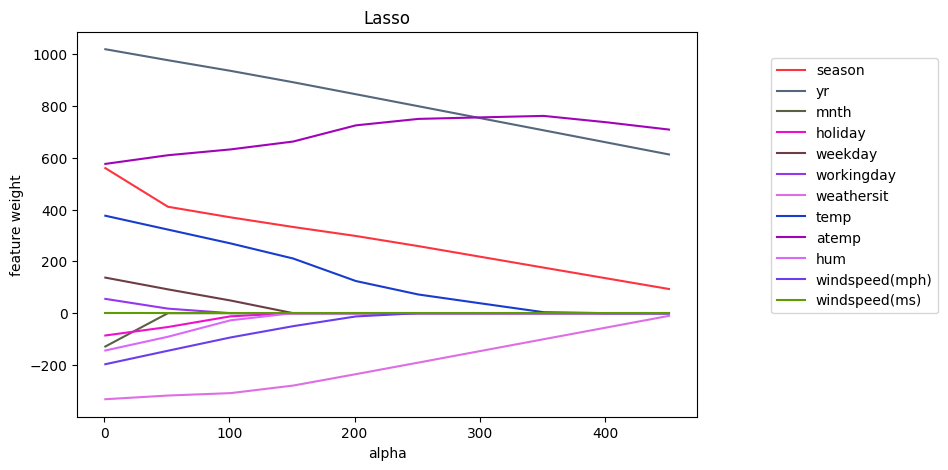

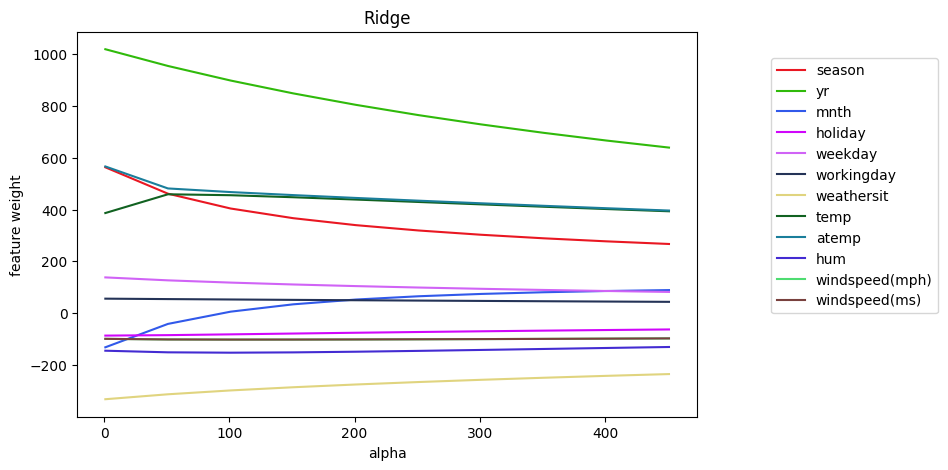

In [27]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(lasso_array.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(ridge_array.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha? Ответ: Lasso.
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит. Ответ: будет происходить более агрессивное уменшение и обнуление весов. Это происходит из-за структуры штрафа, внесенного Lasso, который включает в себя сумму абсолютных значений весов.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
Ответ: Как следует из графика, один из `windspeed` обнулен. В случае Ridge этого не наблюдается. 
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков? Ответ: Lasso.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ частей, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [47]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Оптимальное значение alpha: 6
Признак: season, Вес: 532.0189828413535
Признак: yr, Вес: 1015.0602226430595
Признак: mnth, Вес: -100.03952614356629
Признак: holiday, Вес: -83.29395987529904
Признак: weekday, Вес: 132.50446549095795
Признак: workingday, Вес: 51.557085614073735
Признак: weathersit, Вес: -330.5598567399817
Признак: temp, Вес: 370.67985503003405
Признак: atemp, Вес: 581.396931065498
Признак: hum, Вес: -140.00740550068844
Признак: windspeed(mph), Вес: -191.77140847135036
Признак: windspeed(ms), Вес: -2.6854702314758792e-08


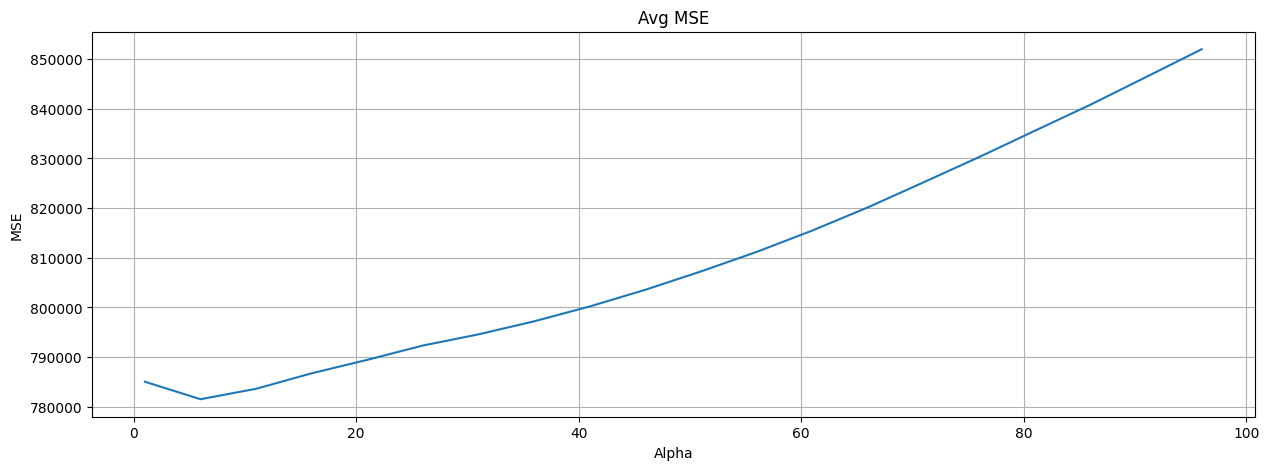

In [50]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

# Создаем и обучаем регрессор LassoCV
regressor = LassoCV(alphas=alphas, cv=3)  # cv - количество фолдов в кросс-валидации
regressor.fit(X, y)
# Оптимальное значение alpha
optimal_alpha = regressor.alpha_
print(f'Оптимальное значение alpha: {optimal_alpha}')
# Выведем пары "признак-коэффициент" для обученного вектора коэффициентов
for feature, weight in zip(df.columns, regressor.coef_):
    print(f"Признак: {feature}, Вес: {weight}")
# Строим график усредненного по строкам MSE в зависимости от alpha
# Для функции create_plot создадим список кортежей пар 'Alpha' и 'MSE'
data = list(zip(regressor.alphas_, regressor.mse_path_.mean(axis=1)))
# print(data)
create_plot(data, 'Avg MSE', 'Alpha', 'MSE')

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Значения alpha, соответствующие минимумам MSE на каждом разбиении:
[ 6  1 51]


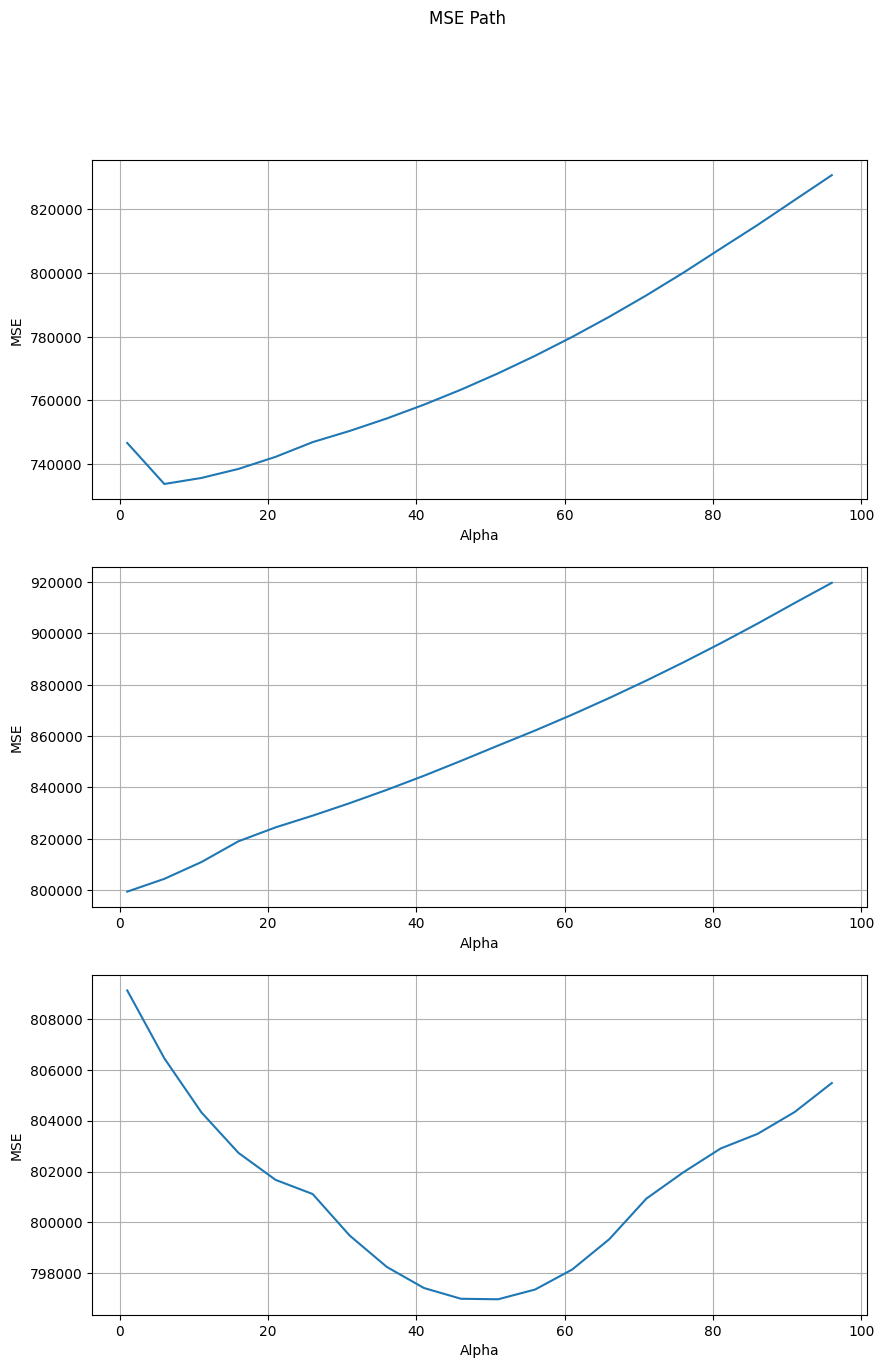

In [63]:
# Вывод значений alpha, соответствующих минимумам MSE на каждом разбиении.
min_alpha = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
print("Значения alpha, соответствующие минимумам MSE на каждом разбиении:")
print(min_alpha)

# Визуализация столбцов mse_path_ на трех отдельных графиках.
fig, axes = plt.subplots(3, 1, figsize=(10, 15))


# Атрибут .mse_path_ в модели LassoCV в scikit-learn представляет собой матрицу, где каждая строка соответствует значению параметра 
# регуляризации (alpha), а каждый столбец представляет собой среднеквадратичную ошибку (MSE) на каждом из разбиений кросс-валидации.
for i in range(3):
    axes[i].plot(regressor.alphas_, regressor.mse_path_[:, i])
    axes[i].set_xlabel('Alpha')
    axes[i].set_ylabel('MSE')
    axes[i].grid()

plt.suptitle('MSE Path')
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

___Ответ 1.1___

In [75]:
# Получение индексов признаков с наибольшими (положительными) коэффициентами.
feature_indices = np.argsort(regressor.coef_)[-4:][::-1]
# Получение имен признаков с наибольшими коэффициентами.
feature_names = df.columns[feature_indices].tolist()
print("4 признака с наибольшими (положительными) коэффициентами:")
print(feature_names)

4 признака с наибольшими (положительными) коэффициентами:
['yr', 'atemp', 'season', 'temp']


___Ответ 1.2___

Возрастающая зависимость наблюдается только для "yr". Тут нелогично утверждать, что чем больше год, тем больше будет заказов. 
Частичная линейность просматривается у "season". В этой зависимости есть логика.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

___Ответ 2.1___

In [107]:
# Выбор трех признаков с наибольшими по модулю отрицательными коэффициентами
negative_coefficients = np.argsort(-regressor.coef_)[:3]
print("3 признака с наибольшими  по модулю отрицательными коэффициентами:")
print(df.columns[negative_coefficients].tolist())

3 признака с наибольшими  по модулю отрицательными коэффициентами:
['yr', 'atemp', 'season']


___Ответ 2.2___

Убывающей линейной зависимости не наблюдается. 

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

___Ответ 3.1___

In [123]:
# Порог для определения коэффициентов, близких к нулю
threshold = 1e-3

# Создание булевого массива для фильтрации коэффициентов
is_near_zero = np.abs(regressor.coef_) < threshold

# Выбор признаков с коэффициентами, близкими к нулю
near_zero_coefficients = df.columns[:-1][is_near_zero].tolist()  # ставим срез [:-1], т.к. колонок в regressor на одну меньше (не включен "cnt")
print("Признаки с коэффициентами, близкими к нулю:")
print(near_zero_coefficients)

Признаки с коэффициентами, близкими к нулю:
['windspeed(ms)']


___Ответ 3.2___

Данный признак исключен (обнулен), т.к. повторяет аналогичный признак "windspeed(mph)". Зависимость количества заказов от этих признаков нелинейная. 

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.